In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (15, 5)

train = pd.read_pickle('Data/student_train_logs_agg')
test = pd.read_pickle('Data/student_test_logs_agg')

target = 'isSTEM'
IDcol = 'ITEST_id'
columns_not_keep = [
    target,
    IDcol,
    'SY ASSISTments Usage',
    'skill',
    'problemId',
    'assignmentId',
    'assistmentId',
    'problemType',
    'SY ASSISTments Usage_std',
    'skill_std',
    'problemId_std',
    'assignmentId_std',
    'assistmentId_std',
    'problemType_std'
]

/home/dario/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/dario/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train_balanced = pd.concat([train[train['isSTEM'] == 1], train[train['isSTEM'] == 0][:150]])
train = train_balanced.sample(frac=1)
train.head()

,SY ASSISTments Usage,AveKnow,AveCarelessness,AveCorrect,NumActions,AveResBored,AveResEngcon,AveResConf,AveResFrust,AveResOfftask,...,confidence(GAMING)_std,RES_BORED_std,RES_CONCENTRATING_std,RES_CONFUSED_std,RES_FRUSTRATED_std,RES_OFFTASK_std,RES_GAMING_std,isSTEM,MCAS,SchoolId
ITEST_id,,,,,,,,,,,,,,,,,,,,,
1305,0.0,0.207459,0.128230,0.396396,555.0,0.244073,0.657117,0.104299,0.110147,0.204144,...,0.251379,0.119477,0.166070,0.240975,0.273082,0.241502,0.205807,0.0,26.0,2.0
2222,1.0,0.105145,0.072149,0.323752,661.0,0.254684,0.656020,0.143297,0.100752,0.171005,...,0.274781,0.119784,0.169790,0.299768,0.279035,0.199680,0.247815,0.0,21.0,1.0
3198,1.0,0.583124,0.294009,0.709375,320.0,0.262557,0.667336,0.071080,0.104902,0.268438,...,0.087295,0.144143,0.154402,0.209548,0.275475,0.283440,0.008042,1.0,48.0,1.0
2882,0.0,0.171269,0.106671,0.396584,527.0,0.253872,0.626971,0.167042,0.263373,0.164220,...,0.235712,0.120400,0.175041,0.303973,0.379491,0.179885,0.189992,1.0,20.0,2.0
2156,1.0,0.214956,0.111364,0.460076,263.0,0.268983,0.631586,0.101974,0.195947,0.231619,...,0.195417,0.129700,0.177879,0.250072,0.360027,0.251857,0.156792,0.0,27.0,4.0


In [3]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=7, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric='auc') 
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

[0]	train-auc:0.841595+0.0397866	test-auc:0.568325+0.0741692
[1]	train-auc:0.929255+0.0183572	test-auc:0.58744+0.117483
[2]	train-auc:0.961416+0.0133166	test-auc:0.619376+0.0818158
[3]	train-auc:0.974958+0.00859342	test-auc:0.63663+0.0468595
[4]	train-auc:0.981077+0.00584756	test-auc:0.620726+0.0591905
[5]	train-auc:0.98472+0.00371194	test-auc:0.619552+0.0596424
[6]	train-auc:0.987825+0.00268241	test-auc:0.644122+0.0792185
[7]	train-auc:0.990145+0.00208375	test-auc:0.638798+0.0879868
[8]	train-auc:0.991476+0.00280303	test-auc:0.637528+0.0808359
[9]	train-auc:0.992785+0.00229137	test-auc:0.634434+0.0833627
[10]	train-auc:0.994045+0.00126966	test-auc:0.646633+0.0874723
[11]	train-auc:0.995027+0.00159898	test-auc:0.644879+0.100523
[12]	train-auc:0.995586+0.00137935	test-auc:0.647331+0.0970401
[13]	train-auc:0.995967+0.00130042	test-auc:0.655061+0.0924301
[14]	train-auc:0.996927+0.00120779	test-auc:0.657373+0.0834257
[15]	train-auc:0.997162+0.00120887	test-auc:0.657308+0.0843932
[16]	train

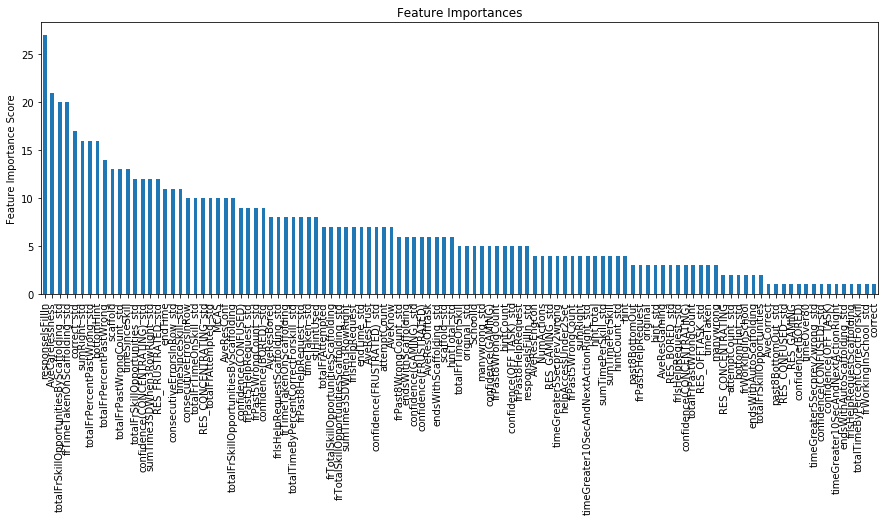

In [7]:
predictors = [x for x in train.columns if x not in columns_not_keep]

xgb1 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

In [9]:
param_test1 = {
 'max_depth': list(range(8,15,2)),
 'min_child_weight': list(range(1,6,2))
}

xgb2 = XGBClassifier(
    learning_rate =0.05,
    n_estimators=105,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

gsearch1 = GridSearchCV(estimator = xgb2, param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=7)
gsearch1.fit(train[predictors], train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.69578, std: 0.07606, params: {'max_depth': 8, 'min_child_weight': 1},
  mean: 0.68336, std: 0.07448, params: {'max_depth': 8, 'min_child_weight': 3},
  mean: 0.67867, std: 0.05144, params: {'max_depth': 8, 'min_child_weight': 5},
  mean: 0.70508, std: 0.07116, params: {'max_depth': 10, 'min_child_weight': 1},
  mean: 0.68336, std: 0.07448, params: {'max_depth': 10, 'min_child_weight': 3},
  mean: 0.67867, std: 0.05144, params: {'max_depth': 10, 'min_child_weight': 5},
  mean: 0.70351, std: 0.07132, params: {'max_depth': 12, 'min_child_weight': 1},
  mean: 0.68336, std: 0.07448, params: {'max_depth': 12, 'min_child_weight': 3},
  mean: 0.67867, std: 0.05144, params: {'max_depth': 12, 'min_child_weight': 5},
  mean: 0.70351, std: 0.07132, params: {'max_depth': 14, 'min_child_weight': 1},
  mean: 0.68336, std: 0.07448, params: {'max_depth': 14, 'min_child_weight': 3},
  mean: 0.67867, std: 0.05144, params: {'max_depth': 14, 'min_child_weight': 5}],
 {'max_depth': 10, 'min_child_

In [12]:
param_test2 = {
 'max_depth': [9,10,11],
 'min_child_weight':[1, 2]
}

xgb3 = XGBClassifier(
    learning_rate =0.05,
    n_estimators=105,
    max_depth=3,
    min_child_weight=5,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

gsearch2 = GridSearchCV(estimator = xgb3, param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=7)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_


([mean: 0.69568, std: 0.06622, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.69118, std: 0.08032, params: {'max_depth': 9, 'min_child_weight': 2},
  mean: 0.70508, std: 0.07116, params: {'max_depth': 10, 'min_child_weight': 1},
  mean: 0.69118, std: 0.08032, params: {'max_depth': 10, 'min_child_weight': 2},
  mean: 0.70351, std: 0.07132, params: {'max_depth': 11, 'min_child_weight': 1},
  mean: 0.69118, std: 0.08032, params: {'max_depth': 11, 'min_child_weight': 2}],
 {'max_depth': 10, 'min_child_weight': 1},
 0.7050797591763978)

* max_depth: 10
* min_child_weight: 1
* learning_rate: 0.05
* n_estimators: 105

In [17]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0, 5)]
}

xgb4 = XGBClassifier(
    learning_rate =0.05,
    n_estimators=105,
    max_depth=10,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)

gsearch3 = GridSearchCV(estimator = xgb4, param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=7)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.70508, std: 0.07116, params: {'gamma': 0.0},
  mean: 0.68739, std: 0.07396, params: {'gamma': 0.1},
  mean: 0.68470, std: 0.07648, params: {'gamma': 0.2},
  mean: 0.68408, std: 0.07583, params: {'gamma': 0.3},
  mean: 0.69323, std: 0.07027, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.7050797591763978)

[0]	train-auc:0.879588+0.0214981	test-auc:0.593013+0.0686433
[1]	train-auc:0.952455+0.0112765	test-auc:0.611895+0.102693
[2]	train-auc:0.977102+0.0092349	test-auc:0.606164+0.0878424
[3]	train-auc:0.984958+0.00702395	test-auc:0.612808+0.0513435
[4]	train-auc:0.989856+0.00407974	test-auc:0.620007+0.0731328
[5]	train-auc:0.991874+0.00284982	test-auc:0.628725+0.066072
[6]	train-auc:0.994058+0.00241654	test-auc:0.633717+0.082876
[7]	train-auc:0.995968+0.00165426	test-auc:0.639783+0.0874451
[8]	train-auc:0.996481+0.00157411	test-auc:0.650831+0.0864512
[9]	train-auc:0.997576+0.00119915	test-auc:0.658022+0.0933177
[10]	train-auc:0.998056+0.000669218	test-auc:0.649781+0.0911669
[11]	train-auc:0.998324+0.000679345	test-auc:0.655928+0.101798
[12]	train-auc:0.998604+0.000745187	test-auc:0.659629+0.103209
[13]	train-auc:0.99876+0.000638626	test-auc:0.670134+0.107812
[14]	train-auc:0.99904+0.00054887	test-auc:0.666612+0.109866
[15]	train-auc:0.99914+0.000470171	test-auc:0.665719+0.104175
[16]	train-

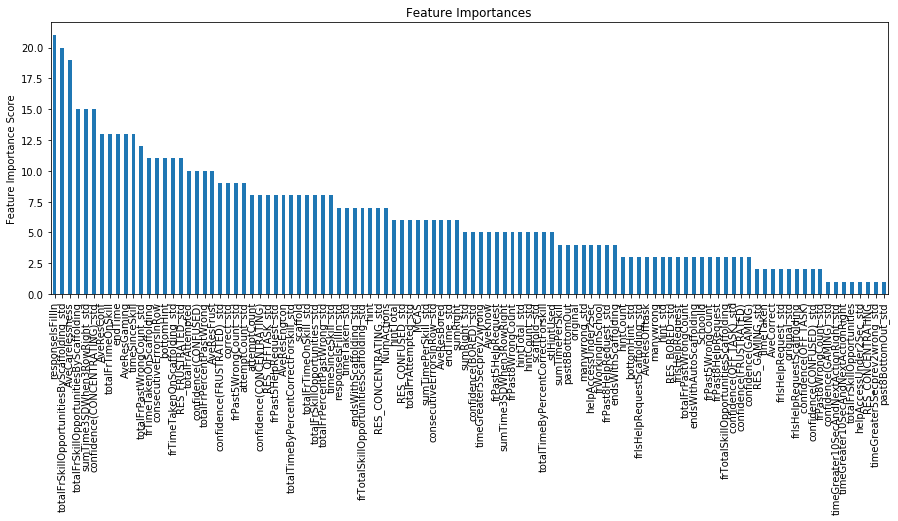

In [20]:
xgb5 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb5, train, predictors, cv_folds=7)

In [21]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb6 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=105,
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

gsearch4 = GridSearchCV(estimator = xgb6, param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=7)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.68595, std: 0.07424, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.68971, std: 0.08140, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.67126, std: 0.07678, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.69214, std: 0.07700, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.68305, std: 0.08017, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.70227, std: 0.07892, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.68268, std: 0.07265, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.68382, std: 0.08140, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.69886, std: 0.07492, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.70026, std: 0.07632, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.70508, std: 0.07116, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.70186, std: 0.07919, params: {'colsample_bytree': 0.8, 'subsample'

[0]	train-auc:0.879588+0.0214981	test-auc:0.593013+0.0686433
[1]	train-auc:0.954112+0.0098755	test-auc:0.596775+0.102291
[2]	train-auc:0.979066+0.005624	test-auc:0.602782+0.0984352
[3]	train-auc:0.987526+0.00420578	test-auc:0.624353+0.05914
[4]	train-auc:0.990954+0.00295164	test-auc:0.625948+0.0516179
[5]	train-auc:0.993561+0.00239239	test-auc:0.620038+0.052072
[6]	train-auc:0.995473+0.00173514	test-auc:0.623763+0.0629511
[7]	train-auc:0.996925+0.0013735	test-auc:0.634136+0.0756151
[8]	train-auc:0.997785+0.0012142	test-auc:0.647963+0.0731723
[9]	train-auc:0.99849+0.000970884	test-auc:0.658146+0.0834775
[10]	train-auc:0.99878+0.000808923	test-auc:0.662026+0.0774524
[11]	train-auc:0.99907+0.000985953	test-auc:0.660881+0.0770237
[12]	train-auc:0.999395+0.00053481	test-auc:0.657271+0.0863627
[13]	train-auc:0.999642+0.000276993	test-auc:0.658798+0.0741927
[14]	train-auc:0.999731+0.000191558	test-auc:0.659431+0.0798422
[15]	train-auc:0.999832+0.000113959	test-auc:0.667384+0.0779282
[16]	trai

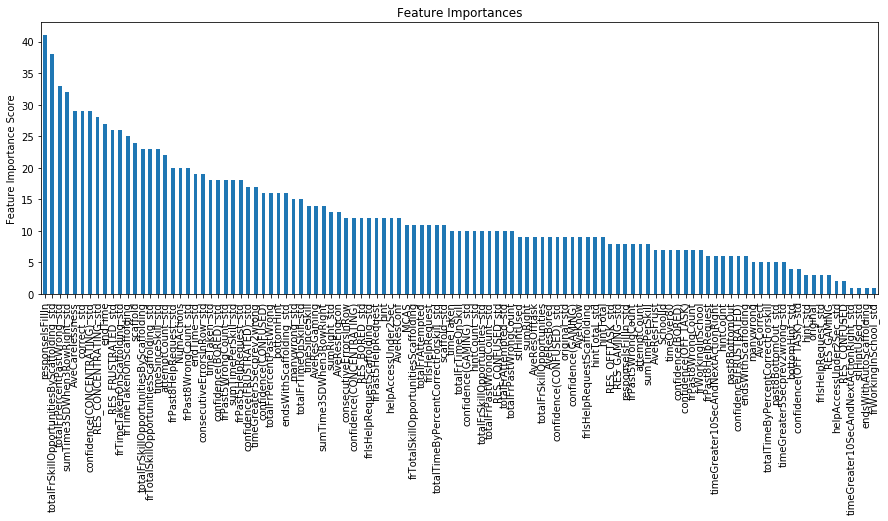

In [30]:
xgbFinal = XGBClassifier(
 learning_rate =0.09,
 n_estimators=124,
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgbFinal, train, predictors, cv_folds=7)

## Predictions

In [31]:
predictors = [x for x in train.columns if x not in columns_not_keep]
for probas in xgbFinal.predict_proba(test[predictors]):
    print(probas[1], end=',')

0.93811,0.663371,0.789936,0.557286,0.975347,0.962122,0.311396,0.85063,0.963693,0.534827,0.067842,0.849464,0.33241,0.838529,0.9636,0.821373,0.325531,0.0468129,0.23982,0.0298625,0.76284,0.443346,0.864902,0.136778,0.0217904,0.310925,0.3173,0.0654627,0.275939,0.664607,0.708833,0.0604083,0.0527129,0.42004,0.0510855,0.346752,0.108047,0.386085,0.594555,0.968953,0.353209,0.936373,0.0247002,0.480072,0.038557,0.0859173,0.103049,0.0378343,0.945846,0.102407,0.890684,0.00764613,0.916095,0.107915,0.690703,0.924908,0.0262992,0.589573,0.696159,0.933899,0.568007,0.908507,0.957313,0.56311,0.738082,0.956192,0.167665,0.987343,0.954508,0.415476,0.954963,0.0961257,0.944089,0.115299,0.97267,0.554556,0.130273,0.940517,0.937467,0.96728,0.949534,0.912879,0.164484,0.970108,0.866502,0.858048,0.611453,0.215853,0.198677,0.91325,0.66098,0.523122,0.989402,0.692694,0.963627,0.941425,0.215599,0.973389,0.0585238,0.628685,0.966649,0.941143,0.536165,0.954517,0.244823,0.975151,0.961123,0.0244821,0.954528,0.966345,0.952468,